In [1]:
import numpy as np
import numpy.random as npr
import pylab
import curbd
import math
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import torch.optim as optim
import pickle 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
from sklearn.decomposition import PCA
import pickle



c:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sim = torch.load("REAL_SIM.pt")
dtData=sim['params']['dtData'] # time step of training data
# dtData=None
dtFactor=5 # number of interpolation steps for RNN 
# tauRNN=2*sim['params']['tau']/2 # decay constant of RNN 
tauRNN=50 # decay constant of RNN 
dtRNN = 0.002
g=1.5 # instability constant 
tauWN=0.1 #decay constant on filtered white noise inputs
ampInWN=0.01 #input amplitude of filtered white noise 
resetPoints=None
plotStatus=True
regions=None


# Model Definition

In [3]:
import sys 

class CTRNN(nn.Module):
    """Continuous-time RNN."""
    def __init__(self,
                 g,
                 tauRNN,
                 dtRNN,
                 input_units,
                 output_units,
                 dt=None,
                 **kwargs):
      
        super(CTRNN,self).__init__()

        self.tauRNN = tauRNN
        self.dtRNN=dtRNN
        self.g=g
        self.input_units=input_units
        self.output_units=output_units
        self.J = nn.Parameter(self.g * torch.Tensor(npr.randn(input_units, output_units) / math.sqrt(output_units)))

    def forward(self, hidden, noise=None):
        if(noise is not None):
           noise = torch.zeros_like(noise)
        
        """Propogate input through the network."""
        
        # When calculating fixed points: We want to find _hidden_ vectors such that -hidden + JR equals the 0 vector.
        activation = torch.tanh(torch.Tensor(hidden))
        JR = torch.matmul(self.J, activation).reshape((self.input_units,1))
        

        new_hidden = hidden + self.dtRNN*(-hidden + JR)/self.tauRNN
        return activation, new_hidden



In [4]:
class pseudomodel(nn.Module):
    def __init__(self, hidden_size, input_units):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_units = input_units
        self.candidate_hidden = nn.Parameter(10*(torch.rand(hidden_size)-0.5))
        

    def forward(self, J_matrix):
        activation = torch.tanh(torch.Tensor(self.candidate_hidden))
        JR = torch.matmul(J_matrix, activation).reshape((self.input_units, 1))
        
        difference = -self.candidate_hidden + JR
        return difference

    

In [55]:
number_units = 300
rnn_model = CTRNN(g=g,
                  tauRNN=tauRNN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units)

rnn_model.to(device)

weights_initial = rnn_model.J.detach().cpu().numpy().copy()


rnn_model.load_state_dict(torch.load("REAL_WEIGHTS_NONOISE.pt"))

<All keys matched successfully>

In [56]:

def find_fixed_points(model, num_to_find=10, epochs=8000):
    fixed_points = []

    training_epochs = epochs

    for index in range(num_to_find):
        loss_function = nn.MSELoss()
        sm = pseudomodel(hidden_size=(300,1), input_units=300)
        optimizer = torch.optim.Adam(sm.parameters(), lr=1e-2)
        
        print(f"Starting to look for fixed point {index}.")
        for i in range(training_epochs):
            diffs = sm(rnn_model.J)
            loss = loss_function(diffs, torch.zeros_like(diffs))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        #   print(i, loss)
        print(f"Finished approximating. The error is {torch.sum((rnn_model(sm.candidate_hidden)[1] - sm.candidate_hidden) ** 2)}. The final loss is {loss}")
        fixed_points.append(sm.candidate_hidden.detach().clone())

    return fixed_points

fixed_points = find_fixed_points(rnn_model)
torch.save(fixed_points, "fixed_points.pt")
            

Starting to look for fixed point 0.
Finished approximating. The error is 3.56752494212742e-08. The final loss is 0.07435458153486252
Starting to look for fixed point 1.
Finished approximating. The error is 4.412299503542272e-08. The final loss is 0.09184333682060242
Starting to look for fixed point 2.
Finished approximating. The error is 5.337530240012711e-08. The final loss is 0.11121055483818054
Starting to look for fixed point 3.
Finished approximating. The error is 4.10265172945401e-08. The final loss is 0.08528874069452286
Starting to look for fixed point 4.
Finished approximating. The error is 2.3863570675075607e-08. The final loss is 0.04971299692988396
Starting to look for fixed point 5.
Finished approximating. The error is 1.740303900987783e-08. The final loss is 0.036254849284887314
Starting to look for fixed point 6.
Finished approximating. The error is 6.730807911026204e-08. The final loss is 0.14023804664611816
Starting to look for fixed point 7.
Finished approximating. Th

In [57]:
fixed_points = torch.load("REAL_FIXED_POINTS.pt")

In [58]:
pca = PCA(n_components=3)
pca2 = PCA(n_components=2)

In [59]:
def run_trajectory(model, starting_point, iterations=100):
    trajectory = []
    trajectory.append(starting_point)
    for iteration in range(iterations):
        activation, new_hidden = model(starting_point)
        trajectory.append(new_hidden)
        starting_point = new_hidden
    
    return torch.cat(trajectory, dim=1).detach().numpy().T

In [35]:
def get_all_trajectories(model, candidate_points, iterations=30000):
    all_trajectories = []
    for starting_point in candidate_points:
        
        trajectory = run_trajectory(model=model, starting_point=starting_point, iterations=iterations)
        all_trajectories.append(trajectory)
    
    return all_trajectories

In [62]:
all_trajectories = get_all_trajectories(rnn_model, fixed_points, iterations=60000)


In [ ]:

g = 1.5
rnn_model = CTRNN(g=g,
                  tauRNN=tauRNN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units)

rnn_model.to(device)
rnn_model.load_state_dict(torch.load("REAL_WEIGHTS_NONOISE.pt"))
weights_initial = rnn_model.J.detach().cpu().numpy().copy()


In [ ]:
def run_trajectory(model, starting_point, iterations=100, form='nparray'):
    trajectory = []
    trajectory.append(starting_point)
    for iteration in range(iterations):
        activation, new_hidden = model(starting_point)
        trajectory.append(new_hidden)
        starting_point = new_hidden
    
    if(form == 'nparray'):
       return torch.cat(trajectory, dim=1).detach().numpy().T
    else:
       return torch.cat(trajectory, dim=1).detach().T

In [ ]:
fixed_points = torch.load("REAL_FIXED_POINTS.pt")
random_point = (torch.rand_like(fixed_points[0])-0.5) * 10
random_points = [(torch.rand_like(fixed_points[0])-0.5) * 400 for _ in range(10)]


In [ ]:
trajectories = [run_trajectory(rnn_model, fixed_points[i], iterations=200000,  form='torch') for i in range(len(fixed_points)) ]
random_trajectories = [run_trajectory(rnn_model, random_points[i], iterations=200000,  form='torch') for i in range(len(random_points)) ]

In [ ]:
'''random_trajectories = torch.load('10r_200k.pt')
trajectories = torch.load("10_200k.pt")'''

In [ ]:
all = torch.cat(trajectories, dim=0)
pca.fit(all)

In [ ]:
# fitted = [pca.transform(trajectory) for trajectory in trajectories]
random_fitted = [pca.transform(trajectory) for trajectory in random_trajectories]

In [ ]:
fitted_1 = pca.transform(random_trajectories[0])

In [ ]:
colormaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

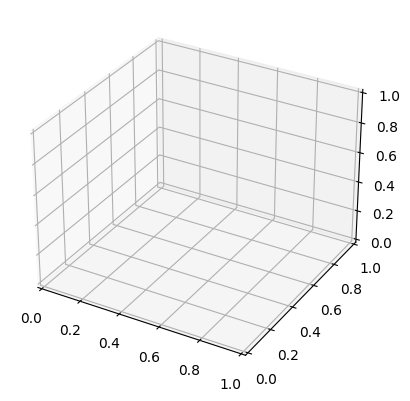

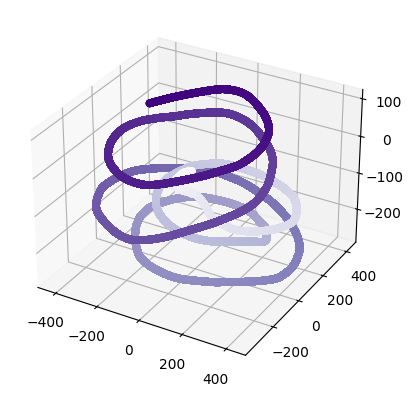

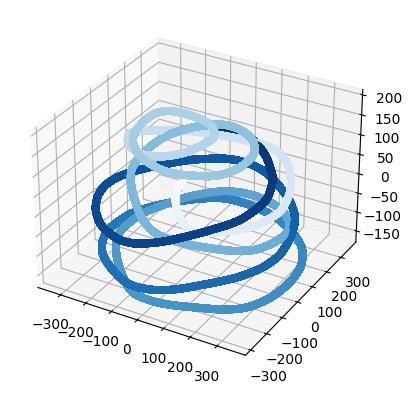

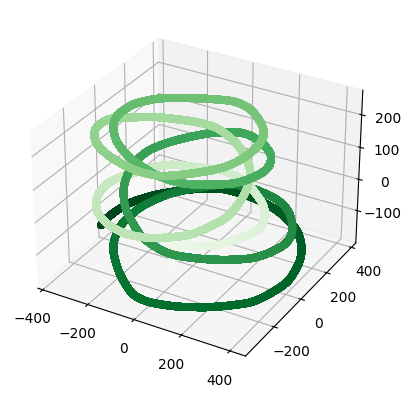

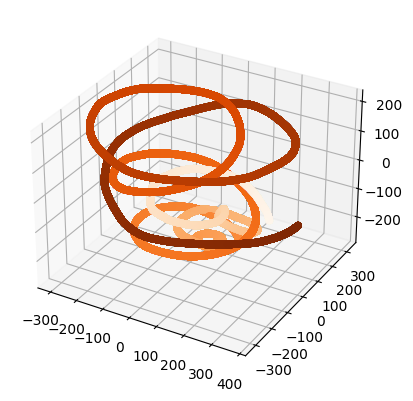

In [ ]:
xs = [fitted_i[:,0] for fitted_i in random_fitted]
ys = [fitted_i[:,1] for fitted_i in random_fitted]
zs = [fitted_i[:,2] for fitted_i in random_fitted]

x_1 = fitted_1[:,0]

fig = plt.figure()
ax = plt.axes(projection='3d')

for index in range(len(xs)):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(xs[index], ys[index], zs[index], c=np.arange(0,x_1.shape[0]), cmap=colormaps[index], label='trajectory near fixed point', linewidth=1.0)
    plt.show()

#ax.legend()
plt.show()
